# Imports Lib & Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install sklearn

In [ ]:
!pip install catboost

     |████████████████████████████████| 67.4 MB 27 kB/s 


In [ ]:
!pip install shap

     |████████████████████████████████| 356 kB 4.2 MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491648 sha256=38c0aa111c9e39ee328a7af4cd8006a269a1be24ea1126272b835f88702bca97
  Stored in directory: /root/.cache/pip/wheels/ca/25/8f/6ae5df62c32651cd719e972e738a8aaa4a87414c4d2b14c9c0
Successfully built shap


In [ ]:
#Imports libs
import pandas as pd
import numpy as np 
import os
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import datetime
import collections
import shap #
from joblib import dump, load
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, roc_auc_score, plot_confusion_matrix, fbeta_score, make_scorer
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder, PolynomialFeatures
from sklearn.tree import DecisionTreeClassifier

#pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)

In [ ]:
# Import data set
path ="/content/drive/MyDrive/Data.Projet3/Projet7/Projet+credit/"

app_train = pd.read_csv(path+"application_train.csv", index_col = "SK_ID_CURR")
print('Training data shape: ', app_train.shape)

Training data shape:  (307511, 121)


Le data set contient 307511 observations (chaque ligne correspond à un prêt) avec 122 features (variables) incluant la colonne `TARGET` (à predire).

# Exploratory Data Analysis (EDA)

Exploratory Data Analysis (EDA) est une étape importante où on fait une anlayse statistique et découvre une tendance, une anormlaie ou encore des corrélations entre des variables.

### Examine the Distribution of the Target Column

Le 'TARGET' est la variable à prédire : la valeur "0" est correspond aux prêts remboursés sans défaut de paiement et "1" indique le défaut de paiement par les clients.
On regarde la répartition de 'TARGET' :

In [ ]:
app_train['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

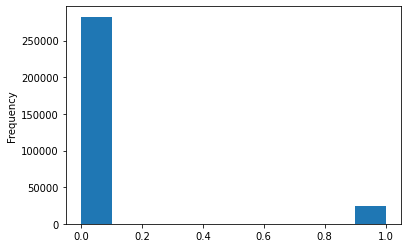

In [ ]:
app_train['TARGET'].astype(int).plot.hist();

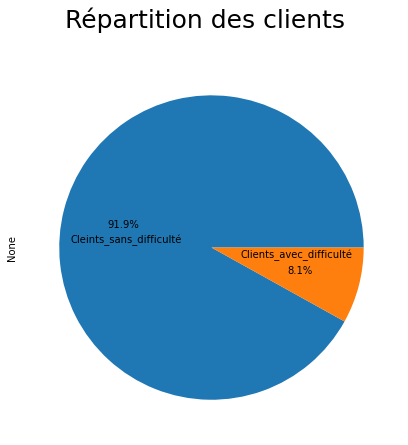

In [ ]:
#Pie chart : répartition des clients
good_client = app_train.groupby('TARGET').size()[0]
bad_client = app_train.groupby('TARGET').size()[1]
target = [good_client, bad_client]
target_client = pd.Series(target, index=("Cleints_sans_difficulté",
                                          "Clients_avec_difficulté"))
fig = plt.figure()
target_client.plot.pie(labeldistance=0.2,
                       autopct='%1.1f%%',
                       figsize=(7,7))
fig.suptitle('Répartition des clients', fontsize=25)
plt.show(block=True)
fig.savefig('repartition_clients.png')

On observe une répartition forte déséquilibrée : il y a peu de clients n'ayant pas remboursé le prêt.
Lors de l'apprentissage de Machine Learning, il va falloir pondérer les classes afin d'effacer cette dèsequilibre des classes.

###Examiner les valeurs manquantes


In [ ]:
# Function to calculate missing values by column 
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[mis_val_table_ren_columns.iloc[:,1] != 0].sort_values('% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Le data set a : " + str(df.shape[1]) + " colonnes.\n"
               "Il y a " + str(mis_val_table_ren_columns.shape[0]) + " colonnes ayant des valeurs manquantes.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [ ]:
#Missing values statistics
missing_values = missing_values_table(app_train)
missing_values.head(5)

Le data set a : 121 colonnes.
Il y a 67 colonnes ayant des valeurs manquantes.


,Missing Values,% of Total Values
COMMONAREA_MEDI,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_MODE,213514,69.4


### types de colonnes


In [ ]:
#Number of each type of column
app_train.dtypes.value_counts()

float64    65
int64      40
object     16
dtype: int64

In [ ]:
#Number of unique classes in each object column
app_train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

La plupart des variables catégorielles ont un nombre relativement faible d'entrées uniques. Nous devrons trouver un moyen de traiter ces variables catégorielles.

### Remplacer les valeurs manquantes


In [ ]:
#list of variables
col_qunti = sorted(list(set(app_train.select_dtypes('float64').columns).union(set(app_train.select_dtypes('int64').columns))))
col_qunti.remove("TARGET")

col_category = sorted(list(set(app_train.select_dtypes('object').columns)))

In [ ]:
def simple_imputer_quanti(dataset):
    for col in col_qunti:
        imputer = SimpleImputer(missing_values= np.nan, strategy='median')        
        dataset[col] = imputer.fit_transform(dataset[col].values.reshape(-1,1))       
    return dataset
def simple_imputer_category(dataset):
    for col in col_category:
        imputer = SimpleImputer(missing_values = np.nan,
                                strategy = "constant",
                                fill_value = "NC")  
        dataset[col] = imputer.fit_transform(dataset[col].values.reshape(-1,1))       
    return dataset

In [ ]:
app_train_imputed = simple_imputer_quanti(app_train)
app_train_imputed = simple_imputer_category(app_train_imputed)

In [ ]:
#Missing values statistics
missing_values2 = missing_values_table(app_train_imputed)
missing_values2.head(5)

Le data set a : 121 colonnes.
Il y a 0 colonnes ayant des valeurs manquantes.


,Missing Values,% of Total Values


#### Encoding Categorical Variables

Avant d'aller plus loin, nous devons nous occuper de ces variables catégorielles.  Un modèle d'apprentissage automatique ne peut malheureusement pas traiter les variables catégorielles (à l'exception de certains modèles). 
Par conséquent, nous devons trouver un moyen de coder ces variables sous forme de nombres avant de les transmettre au modèle. Il y a deux façons principales de réaliser ce processus :

* LabelEncoder : attribuer un nombre entier à chaque catégorie unique d'une variable catégorielle. Aucune nouvelle colonne n'est créée.

* OneHotEncoder : créer une nouvelle colonne pour chaque catégorie unique dans une variable catégorielle.

Le problème de LabelEncoder est qu'il donne aux catégories un ordre arbitraire. La valeur attribuée à chacune des catégories est aléatoire. L'affectation réelle des entiers est arbitraire. Par conséquent, lorsque nous effectuons LabelEncoder, le modèle peut utiliser la valeur relative de la caractéristique pour attribuer des poids, ce qui n'est pas ce que nous voulons. Si nous n'avons que deux valeurs uniques pour une variable catégorielle (comme Male/Female), alors LabelEncoder est correct, mais pour plus de deux catégories uniques, OneHotEncoder est l'option la plus sûre.

##### label encoding

In [ ]:
#Number of each type of column
app_train_imputed.dtypes.value_counts()

float64    104
object      16
int64        1
dtype: int64

In [ ]:
#Number of unique classes in each object column
app_train_imputed.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                8
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               19
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             5
HOUSETYPE_MODE                 4
WALLSMATERIAL_MODE             8
EMERGENCYSTATE_MODE            3
dtype: int64

In [ ]:
le = LabelEncoder()
def LabelEncoding(data_set):
    le_count = 0
    for col in data_set:
        if data_set[col].dtype == 'object':
            if len(list(data_set[col].unique())) <= 2:
                print(col)
                data_set[col] = le.fit_transform(data_set[col])  
                le_count += 1  
    print('%d colonnes a été traité par LabelEncoder.' % le_count)
    return data_set

In [ ]:
app_train_imputed = LabelEncoding(app_train_imputed)
app_train_imputed['TARGET'] = le.fit_transform(app_train_imputed['TARGET'])

NAME_CONTRACT_TYPE
FLAG_OWN_CAR
FLAG_OWN_REALTY
3 colonnes a été traité par LabelEncoder.


##### one-hot encoding

In [ ]:
#dimension before one-hot encoding
print('Before one-hot encoding : training features shape: ', app_train_imputed.shape)
# one-hot encoding of categorical variables
app_train_imputed = pd.get_dummies(app_train_imputed)
print('After one-hot encoding : training features shape: ', app_train_imputed.shape)

Before one-hot encoding : training features shape:  (307511, 121)
After one-hot encoding : training features shape:  (307511, 248)


### Anomalies

In [ ]:
(app_train_imputed['DAYS_BIRTH'] / -365).describe()

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

In [ ]:
app_train_imputed['AGE'] = (app_train_imputed['DAYS_BIRTH']/-365).astype('int64')
app_train_imputed = app_train_imputed.drop(['DAYS_BIRTH'], axis = 1)

Il semble qu'il n'y a pas de valeurs aberrantes pour l'âge (Pas de valeurs trop importante ni trop faible)
Et pour les jours d'emploi ?

In [ ]:
app_train_imputed['DAYS_EMPLOYED'].describe()

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

Il semble qu'il y a des problèmes : des valeurs négatives ainsi des valeurs trop importante ( 365243 jours correspondont à 1000 ans)

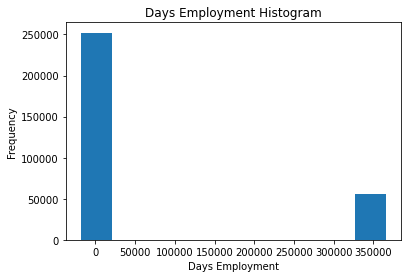

In [ ]:
app_train_imputed['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

In [ ]:
anom = app_train_imputed[app_train_imputed['DAYS_EMPLOYED'] == 365243]
non_anom = app_train_imputed[app_train_imputed['DAYS_EMPLOYED'] != 365243]
print("Il y a %d cleints avec la valeur de 'DAYS_EMPLOYED' anormale" % len(anom))
print("Les clients avec 'DAYS_EMPLOYED' normaux : %0.2f%%  de défaut de remboursement" % (100 * non_anom['TARGET'].mean()))
print("Les clients avec 'DAYS_EMPLOYED' anormaux : %0.2f%% de défaut de remboursement" % (100 * anom['TARGET'].mean()))

Il y a 55374 cleints avec la valeur de 'DAYS_EMPLOYED' anormale
Les clients avec 'DAYS_EMPLOYED' normaux : 8.66%  de défaut de remboursement
Les clients avec 'DAYS_EMPLOYED' anormaux : 5.40% de défaut de remboursement


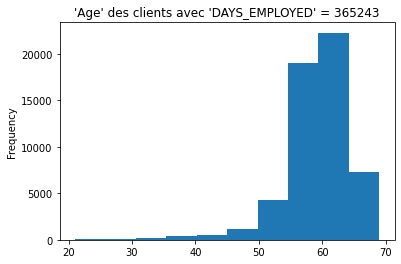

In [ ]:
(anom['AGE']).plot.hist(title = "'Age' des clients avec 'DAYS_EMPLOYED' = 365243")

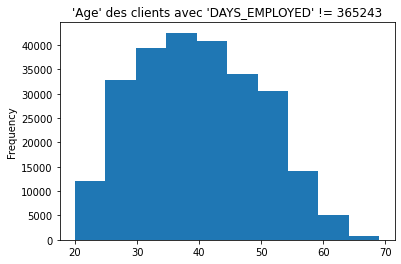

In [ ]:
(non_anom['AGE']).plot.hist(title = "'Age' des clients avec 'DAYS_EMPLOYED' != 365243")

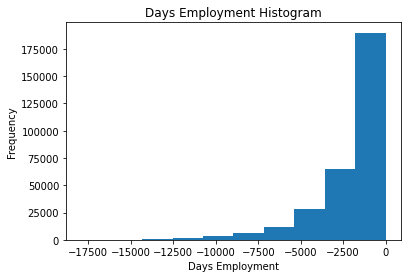

In [ ]:
# Replace the anomalous values with nan
app_train_imputed['DAYS_EMPLOYED'].replace({365243: 0}, inplace = True)

app_train_imputed['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

In [ ]:
app_train_imputed['YEARS_EMPLOYED'] = round((app_train_imputed['DAYS_EMPLOYED']/-365).astype('int64'), 0)
app_train_imputed[["YEARS_EMPLOYED", "DAYS_EMPLOYED"]].head(5)

,YEARS_EMPLOYED,DAYS_EMPLOYED
SK_ID_CURR,,
100002,1,-637.0
100003,3,-1188.0
100004,0,-225.0
100006,8,-3039.0
100007,8,-3038.0


In [ ]:
app_train_imputed = app_train_imputed.drop(['DAYS_EMPLOYED'], axis = 1)

### Correlations

Une manière de comprendre des données est de chercher s'il y a une eventuelle corrélation entre des variables et la variable à prédire.
Le coefficient de corrélation donne une idée des relations possibles. Voici quelques interprétations générales de la valeur absolue du coefficient de corrélation :
* .00-.19 “très faible”
* .20-.39 “faible”
* .40-.59 “moderé”
* .60-.79 “fort”
* .80-1.0 “très fort”

In [ ]:
# Find correlations with the target and sort
correlations = pd.DataFrame(app_train_imputed.corr()['TARGET'].sort_values())
correlations.columns = ["correlation"]
correlations["correlation_absolue"] = correlations["correlation"].apply(lambda x : abs(x))
correlations = correlations.sort_values(by=['correlation_absolue'], ascending = False)

In [ ]:
correlations.head(10)

,correlation,correlation_absolue
TARGET,1.000000,1.000000
EXT_SOURCE_2,-0.160295,0.160295
EXT_SOURCE_3,-0.155892,0.155892
EXT_SOURCE_1,-0.098887,0.098887
AGE,-0.078234,0.078234
REGION_RATING_CLIENT_W_CITY,0.060893,0.060893
REGION_RATING_CLIENT,0.058899,0.058899
NAME_INCOME_TYPE_Working,0.057481,0.057481
NAME_EDUCATION_TYPE_Higher education,-0.056593,0.056593
DAYS_LAST_PHONE_CHANGE,0.055218,0.055218


In [ ]:
#Heatmap
#plt.figure(figsize=(8, 12))
#cmap = sns.palplot(sns.diverging_palette(240, 10, n=250))
#heatmap = sns.heatmap(app_train.corr()[['TARGET']].sort_values(by='TARGET', ascending=False), vmin=-1, vmax=1, annot=True, cmap=cmap)
#heatmap.set_title('Features Correlating with Target', fontdict={'fontsize':18}, pad=16);

#### Effect of Age on Repayment

In [ ]:
# Find the correlation of the positive days since birth and target
app_train_imputed['AGE'].corr(app_train_imputed['TARGET'])

-0.07823418202684651

Plus l'âge du client est important moins de défaut de rembourseement (une corrélation négative)  -> ce qui signifie que plus les clients vieillissent, plus ils ont tendance à rembourser leurs prêts dans les délais. 

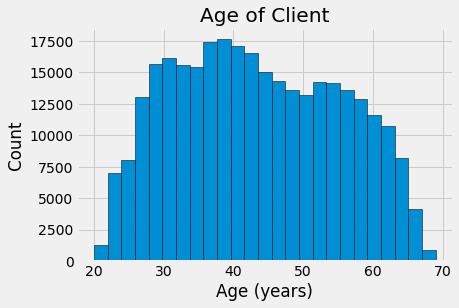

In [ ]:
# Set the style of plots
plt.style.use('fivethirtyeight')

# Plot the distribution of ages in years
plt.hist(app_train_imputed['AGE'], edgecolor = 'k', bins = 25)
plt.title('Age of Client'); plt.xlabel('Age (years)'); plt.ylabel('Count');

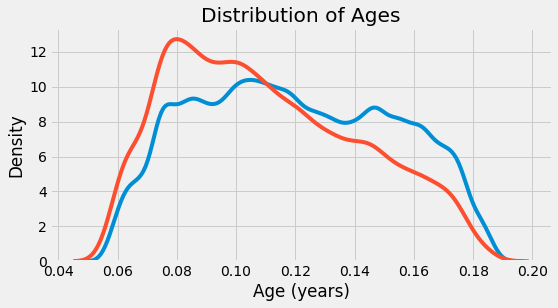

In [ ]:
#kdeplot
plt.figure(figsize = (8, 4))

# KDE plot of loans that were repaid on time
sns.kdeplot(app_train_imputed.loc[app_train_imputed['TARGET'] == 0, 'AGE'] / 365, label = 'target == 0')
# KDE plot of loans which were not repaid on time
sns.kdeplot(app_train_imputed.loc[app_train_imputed['TARGET'] == 1, 'AGE'] / 365, label = 'target == 1')
# Labeling of plot
plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages');

In [ ]:
# Age information into a separate dataframe
age_data = app_train_imputed[['TARGET', 'AGE']]

# Bin the age data
age_data['YEARS_BINNED'] = pd.cut(age_data['AGE'], bins = np.linspace(20, 70, num = 11))

#Group by the bin and calculate averages
age_groups  = age_data.groupby('YEARS_BINNED').mean()
age_groups

,TARGET,AGE
YEARS_BINNED,,
"(20.0, 25.0]",0.117424,23.416743
"(25.0, 30.0]",0.112448,28.155777
"(30.0, 35.0]",0.099754,32.963841
"(35.0, 40.0]",0.086653,37.999794
"(40.0, 45.0]",0.077706,42.927870
"(45.0, 50.0]",0.072957,47.941489
"(50.0, 55.0]",0.064108,53.019489
"(55.0, 60.0]",0.054214,57.959080
"(60.0, 65.0]",0.052383,62.794450


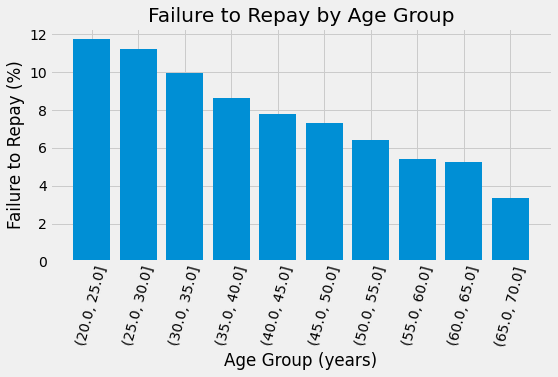

In [ ]:
# barplot : age & target
plt.figure(figsize = (8, 4))

# Graph the age bins and the average of the target as a bar plot
plt.bar(age_groups.index.astype(str), 100 * age_groups['TARGET'])

# Plot labeling
plt.xticks(rotation = 75); plt.xlabel('Age Group (years)'); plt.ylabel('Failure to Repay (%)')
plt.title('Failure to Repay by Age Group');

### Exterior Sources

Les 3 variables ayant les plus fortes corrélations négatives avec la cible sont `EXT_SOURCE_1`, `EXT_SOURCE_2`, et `EXT_SOURCE_3`.

Exist-il une corrélation entre ces trois variables ?

In [ ]:
# Extract the EXT_SOURCE variables and show correlations
ext_data = app_train_imputed[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'AGE']]
ext_data_corrs = ext_data.corr()
ext_data_corrs

,TARGET,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,AGE
TARGET,1.000000,-0.098887,-0.160295,-0.155892,-0.078234
EXT_SOURCE_1,-0.098887,1.000000,0.134993,0.109100,0.362121
EXT_SOURCE_2,-0.160295,0.134993,1.000000,0.094147,0.091853
EXT_SOURCE_3,-0.155892,0.109100,0.094147,1.000000,0.178477
AGE,-0.078234,0.362121,0.091853,0.178477,1.000000


In [ ]:
# Heatmap of correlations
#plt.figure(figsize = (8, 6))
#sns.heatmap(ext_data_corrs, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
#plt.title('Correlation Heatmap');

Les trois caractéristiques `EXT_SOURCE` ont des corrélations négatives avec 'TARGET', ce qui indique que plus la valeur de `EXT_SOURCE` augmente, plus le client est susceptible de rembourser le prêt. 
Nous constatons également que `DAYS_BIRTH` est positivement corrélé avec `EXT_SOURCE_1`, ce qui indique que l'un des facteurs de ce score est peut-être l'âge du client.

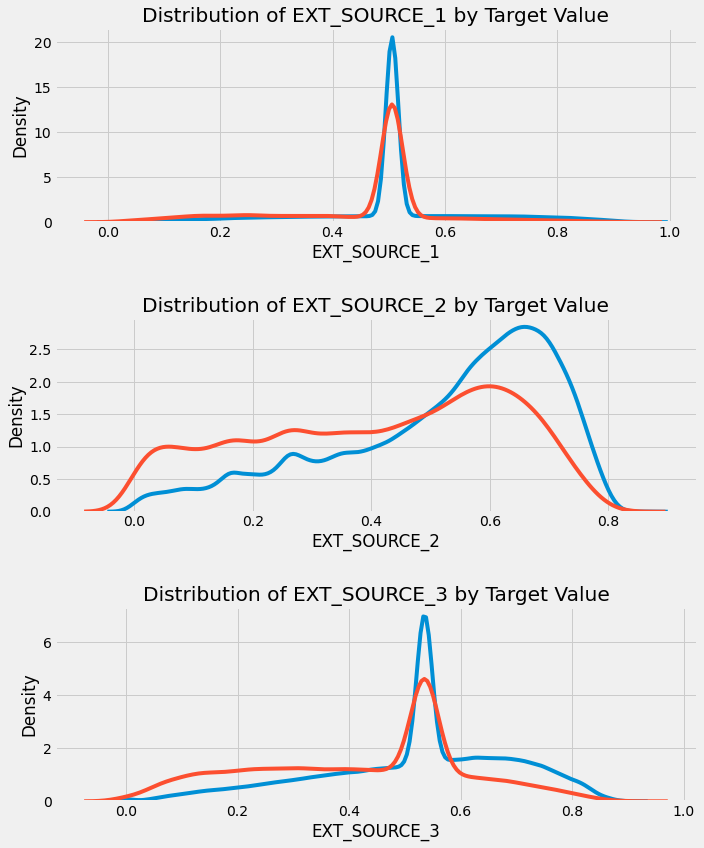

In [ ]:
#distribution of EXT_SOURCE
plt.figure(figsize = (10, 12))

# iterate through the sources
for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):
    
    # create a new subplot for each source
    plt.subplot(3, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(app_train_imputed.loc[app_train_imputed['TARGET'] == 0, source], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(app_train_imputed.loc[app_train_imputed['TARGET'] == 1, source], label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % source)
    plt.xlabel('%s' % source); plt.ylabel('Density');
    
plt.tight_layout(h_pad = 2.5)   

`EXT_SOURCE_3` illustre une différence notable pour deux valeurs de 'TARGET'. Nous pouvons clairement voir que cette variable a une certaine relation avec la probabilité qu'un cleint rembourse un prêt. Malgré une corrélation faible, ces variables seront tout de même utiles à pour la suite.

# Feature Engineering

### Polynomial Features

In [ ]:
# Make a new dataframe for polynomial features
col_poly = sorted(['AGE', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3'])
poly_features = app_train_imputed[col_poly]

#imputer = SimpleImputer(strategy = 'median')
poly_transformer = PolynomialFeatures(degree = 3)
poly_transformer.fit(poly_features)
poly_features = poly_transformer.transform(poly_features)
print('Polynomial Features shape: ', poly_features.shape)

poly_transformer.get_feature_names(input_features = col_poly)[:10]

# Create a dataframe of the features 
poly_features = pd.DataFrame(poly_features, 
                             columns = poly_transformer.get_feature_names(col_poly))

# Add in the target
poly_features['TARGET'] = app_train_imputed['TARGET']

Polynomial Features shape:  (307511, 35)


In [ ]:
# Find the correlations with the target
poly_corrs = poly_features.corr()['TARGET'].sort_values()

# Display most negative and most positive
print(poly_corrs.head(10))
print()
print(poly_corrs.tail(5))

EXT_SOURCE_3^3                  -0.005448
EXT_SOURCE_3^2                  -0.004932
AGE EXT_SOURCE_3^2              -0.004862
EXT_SOURCE_3                    -0.004023
EXT_SOURCE_1 EXT_SOURCE_3^2     -0.003921
AGE EXT_SOURCE_3                -0.003840
AGE^2 EXT_SOURCE_3              -0.003085
AGE EXT_SOURCE_1 EXT_SOURCE_3   -0.002702
EXT_SOURCE_1 EXT_SOURCE_3       -0.002701
EXT_SOURCE_2 EXT_SOURCE_3^2     -0.002487
Name: TARGET, dtype: float64

EXT_SOURCE_1 EXT_SOURCE_2      0.001634
EXT_SOURCE_1 EXT_SOURCE_2^2    0.001659
EXT_SOURCE_1^2 EXT_SOURCE_2    0.002161
TARGET                         1.000000
1                                   NaN
Name: TARGET, dtype: float64


In [ ]:
poly_features = poly_features.drop(col_poly, axis = 1)
poly_features = poly_features.drop(['TARGET'], axis = 1)

In [ ]:
# Merge polynomial features into training dataframe
poly_features.index = app_train_imputed.index
app_train_poly = app_train_imputed.merge(poly_features, left_index=True, right_index=True)

# Print out the new shapes
print('Training data with polynomial features shape: ', app_train_poly.shape)

Training data with polynomial features shape:  (307511, 279)


### Fonctionnalités de connaissance du domaine
Peut-être qu'il n'est pas tout à fait correct d'appeler cela « connaissance du domaine » parce que je ne suis pas un expert en crédit, mais peut-être pourrions-nous appeler cela « tentatives d'appliquer des connaissances financières limitées ». Dans cet état d'esprit, nous pouvons créer quelques fonctionnalités qui tentent de capturer ce que nous pensons être important pour savoir si un client fera défaut sur un prêt. Ici, je vais utiliser cinq fonctionnalités qui ont été inspirées par ce script d'Aguiar :

* `CREDIT_INCOME_PERCENT`: 
le pourcentage du montant du crédit par rapport aux revenus d'un client
* `ANNUITY_INCOME_PERCENT`: le pourcentage de la rente du prêt par rapport au revenu d'un client
* `CREDIT_TERM`:  
la durée du versement en mois (puisque la rente est le montant mensuel)
* `DAYS_EMPLOYED_PERCENT`: le pourcentage des jours de travail par rapport à l'âge du client


In [ ]:
#add new variables
app_train_poly["YEARS_EMPLOYED_PERCENT"] = app_train_poly["YEARS_EMPLOYED"] / app_train_poly["AGE"]
app_train_poly["CREDIT_ANNUITY_RATIO"] = app_train_poly["AMT_CREDIT"] / app_train_poly["AMT_ANNUITY"]
app_train_poly["INCOME_ANNUITY_RATIO"] = app_train_poly["AMT_INCOME_TOTAL"] / app_train_poly["AMT_ANNUITY"]
app_train_poly["INCOME_CREDIT_RATIO"] = app_train_poly["AMT_INCOME_TOTAL"] / app_train_poly["AMT_CREDIT"]
app_train_poly["CREDIT_GOODS_PRICE_RATIO"] = app_train_poly["AMT_CREDIT"] / app_train_poly["AMT_GOODS_PRICE"]
app_train_poly["CREDIT_DOWNPAYMENT"] = app_train_poly["AMT_GOODS_PRICE"] / app_train_poly["AMT_CREDIT"]
app_train_poly["CREDIT_INCOME_PERCENT"] = app_train_poly["AMT_CREDIT"] / app_train_poly["AMT_INCOME_TOTAL"]
app_train_poly["ANNUITY_INCOME_PERCENT"] = app_train_poly["AMT_ANNUITY"] / app_train_poly["AMT_INCOME_TOTAL"]
app_train_poly["RATIO_CREDIT_GOODS_PRICE"] = app_train_poly["AMT_CREDIT"] / app_train_poly["AMT_GOODS_PRICE"]
app_train_poly["DIFF_GOODS_PRICE_CREDIT"] = app_train_poly["AMT_CREDIT"] - app_train_poly["AMT_GOODS_PRICE"]
app_train_poly['CREDIT_TERM'] = app_train_poly['AMT_ANNUITY'] / app_train_poly['AMT_CREDIT']

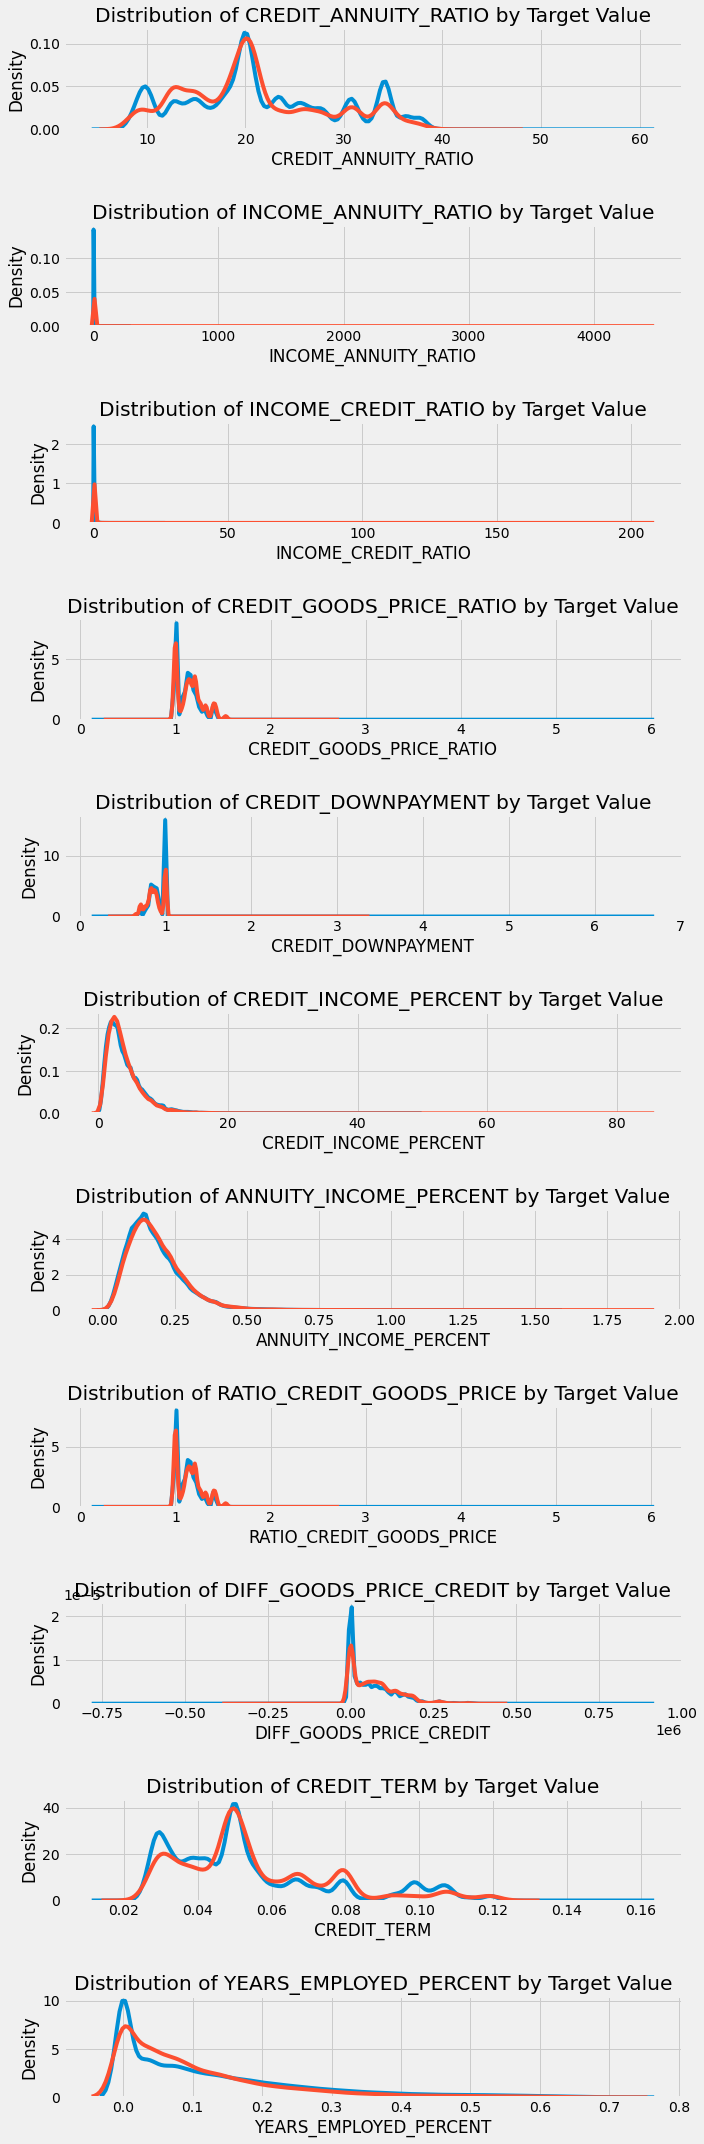

In [ ]:
#Plot
plt.figure(figsize = (10, 30))
# iterate through the new features
for i, feature in enumerate(['CREDIT_ANNUITY_RATIO',
                             'INCOME_ANNUITY_RATIO',
                             'INCOME_CREDIT_RATIO',
                             'CREDIT_GOODS_PRICE_RATIO',
                             'CREDIT_DOWNPAYMENT',
                             'CREDIT_INCOME_PERCENT',
                             'ANNUITY_INCOME_PERCENT',
                             'RATIO_CREDIT_GOODS_PRICE',
                             'DIFF_GOODS_PRICE_CREDIT',
                             'CREDIT_TERM',
                             'YEARS_EMPLOYED_PERCENT']):
    
    # create a new subplot for each source
    plt.subplot(11, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(app_train_poly.loc[app_train_poly['TARGET'] == 0, feature], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(app_train_poly.loc[app_train_poly['TARGET'] == 1, feature], label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % feature)
    plt.xlabel('%s' % feature); plt.ylabel('Density');
    
plt.tight_layout(h_pad = 2.5)

In [ ]:
min_max_scaler = MinMaxScaler(feature_range = (0, 1))
app_train_poly = pd.DataFrame(min_max_scaler.fit_transform(app_train_poly),
                              index=app_train_poly.index,
                              columns=app_train_poly.columns)

In [ ]:
app_train_poly.head(2)

,TARGET,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,...,AGE EXT_SOURCE_1,AGE EXT_SOURCE_2,AGE EXT_SOURCE_3,EXT_SOURCE_1^2,EXT_SOURCE_1 EXT_SOURCE_2,EXT_SOURCE_1 EXT_SOURCE_3,EXT_SOURCE_2^2,EXT_SOURCE_2 EXT_SOURCE_3,EXT_SOURCE_3^2,AGE^3,AGE^2 EXT_SOURCE_1,AGE^2 EXT_SOURCE_2,AGE^2 EXT_SOURCE_3,AGE EXT_SOURCE_1^2,AGE EXT_SOURCE_1 EXT_SOURCE_2,AGE EXT_SOURCE_1 EXT_SOURCE_3,AGE EXT_SOURCE_2^2,AGE EXT_SOURCE_2 EXT_SOURCE_3,AGE EXT_SOURCE_3^2,EXT_SOURCE_1^3,EXT_SOURCE_1^2 EXT_SOURCE_2,EXT_SOURCE_1^2 EXT_SOURCE_3,EXT_SOURCE_1 EXT_SOURCE_2^2,EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3,EXT_SOURCE_1 EXT_SOURCE_3^2,EXT_SOURCE_2^3,EXT_SOURCE_2^2 EXT_SOURCE_3,EXT_SOURCE_2 EXT_SOURCE_3^2,EXT_SOURCE_3^3,YEARS_EMPLOYED_PERCENT,CREDIT_ANNUITY_RATIO,INCOME_ANNUITY_RATIO,INCOME_CREDIT_RATIO,CREDIT_GOODS_PRICE_RATIO,CREDIT_DOWNPAYMENT,CREDIT_INCOME_PERCENT,ANNUITY_INCOME_PERCENT,RATIO_CREDIT_GOODS_PRICE,DIFF_GOODS_PRICE_CREDIT,CREDIT_TERM
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100002,1.0,0.0,0.0,1.0,0.0,0.001512,0.090287,0.090032,0.077441,0.256321,0.852140,0.705433,0.098901,1.0,1.0,0.0,1.0,1.0,0.0,0.000000,0.5,0.5,0.434783,0.0,0.0,0.0,0.0,0.0,0.0,0.072215,0.307542,0.155054,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,...,0.026948,0.119076,0.059000,0.007213,0.029266,0.014650,0.094582,0.052001,0.024196,0.023790,0.010036,0.043778,0.021633,0.002762,0.011125,0.005466,0.038567,0.020029,0.009387,0.000638,0.002563,0.001302,0.009369,0.004920,0.002314,0.029088,0.016330,0.008212,0.003764,0.054694,0.190409,0.001716,0.002338,0.172376,0.107168,0.023640,0.064910,0.172376,0.492851,0.311054
100003,0.0,0.0,0.0,0.0,0.0,0.002089,0.311736,0.132924,0.271605,0.045016,0.951929,0.959566,0.098901,1.0,1.0,0.0,1.0,1.0,0.0,0.052632,0.0,0.0,0.478261,0.0,0.0,0.0,0.0,0.0,0.0,0.312933,0.727773,0.597163,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,...,0.214191,0.507210,0.408976,0.104337,0.259609,0.211148,0.529654,0.472602,0.356887,0.259353,0.143033,0.335654,0.269854,0.072118,0.177634,0.141819,0.388752,0.327660,0.249214,0.033798,0.085217,0.070268,0.196667,0.167608,0.127953,0.385468,0.351196,0.286645,0.213204,0.091156,0.561831,0.001574,0.000947,0.170120,0.108699,0.056483,0.070368,0.170120,0.557959,0.076481


# Classification

### Split Dataset

In [ ]:
def sampling(df, sample_size):
    df = df.copy()
    print('la taill de dataset initial : ', df.shape)
    df = df.reset_index(drop = True)
    df_sample0 = df[df['TARGET'] == 0]
    df_sample1 = df[df['TARGET'] == 1]
    n0 = round(len(df_sample0)*sample_size)
    n1 = round(len(df_sample1)*sample_size)
    print('le nombre de lignes de df_sample0: ', n0)
    print('le nombre de lignes de df_sample1: ', n1)

    df_sample0 = df_sample0.sample(n = n0)
    df_sample1 = df_sample1.sample(n = n1)

    df_sample = pd.concat([df_sample0, df_sample1], axis=0)
    df_sample = df_sample.reset_index(drop=True)
    print('Random under-sampling:')
    print(df_sample.shape)
    print(df_sample.TARGET.value_counts())
    return df_sample

def split_stratified(df, test_size):
    X = df.drop(columns = ['TARGET'])
    y = df['TARGET']
    X = pd.DataFrame(X, columns = X.columns)
    sss = StratifiedShuffleSplit(n_splits=2, test_size=test_size, random_state=0)
    sss.get_n_splits(X, y)
    for train_index, test_index in sss.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    return X_train, X_test, y_train, y_test

In [ ]:
sample_size = 1
df_sample = sampling(app_train_poly, sample_size)

la taill de dataset initial :  (307511, 290)
le nombre de lignes de df_sample0:  282686
le nombre de lignes de df_sample1:  24825
Random under-sampling:
(307511, 290)
0.0    282686
1.0     24825
Name: TARGET, dtype: int64


In [ ]:
X_train, X_test, y_train, y_test = split_stratified(app_train_poly, test_size = 0.25)

In [ ]:
X_tmp = app_train_poly.drop(columns = ['TARGET'])
y_tmp = app_train_poly['TARGET']
X_train, X_test, y_train, y_test = train_test_split(X_tmp, y_tmp, test_size=0.33, random_state=42)

In [ ]:
X_train.head(2)

,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,...,AGE EXT_SOURCE_1,AGE EXT_SOURCE_2,AGE EXT_SOURCE_3,EXT_SOURCE_1^2,EXT_SOURCE_1 EXT_SOURCE_2,EXT_SOURCE_1 EXT_SOURCE_3,EXT_SOURCE_2^2,EXT_SOURCE_2 EXT_SOURCE_3,EXT_SOURCE_3^2,AGE^3,AGE^2 EXT_SOURCE_1,AGE^2 EXT_SOURCE_2,AGE^2 EXT_SOURCE_3,AGE EXT_SOURCE_1^2,AGE EXT_SOURCE_1 EXT_SOURCE_2,AGE EXT_SOURCE_1 EXT_SOURCE_3,AGE EXT_SOURCE_2^2,AGE EXT_SOURCE_2 EXT_SOURCE_3,AGE EXT_SOURCE_3^2,EXT_SOURCE_1^3,EXT_SOURCE_1^2 EXT_SOURCE_2,EXT_SOURCE_1^2 EXT_SOURCE_3,EXT_SOURCE_1 EXT_SOURCE_2^2,EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3,EXT_SOURCE_1 EXT_SOURCE_3^2,EXT_SOURCE_2^3,EXT_SOURCE_2^2 EXT_SOURCE_3,EXT_SOURCE_2 EXT_SOURCE_3^2,EXT_SOURCE_3^3,YEARS_EMPLOYED_PERCENT,CREDIT_ANNUITY_RATIO,INCOME_ANNUITY_RATIO,INCOME_CREDIT_RATIO,CREDIT_GOODS_PRICE_RATIO,CREDIT_DOWNPAYMENT,CREDIT_INCOME_PERCENT,ANNUITY_INCOME_PERCENT,RATIO_CREDIT_GOODS_PRICE,DIFF_GOODS_PRICE_CREDIT,CREDIT_TERM
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
436794,0.0,0.0,1.0,0.0,0.001320,0.197348,0.123412,0.158249,0.245631,0.784330,0.894123,0.098901,1.0,1.0,0.0,1.0,0.0,0.0,0.052632,1.0,1.0,0.521739,0.0,0.0,0.0,0.0,0.0,0.0,0.704582,0.505121,0.184124,0.0876,0.0763,0.9816,0.7552,0.0211,0.0,0.1379,0.1667,0.2083,...,0.497857,0.367683,0.131868,0.502641,0.395141,0.143080,0.255148,0.101361,0.034079,0.298971,0.344809,0.254134,0.090927,0.362611,0.282386,0.100374,0.195595,0.073398,0.024855,0.356477,0.284439,0.104425,0.20776,0.078832,0.026794,0.128881,0.052279,0.018998,0.006291,0.320017,0.353005,0.001092,0.000979,0.185915,0.098669,0.054716,0.098388,0.185915,0.555784,0.162915
354174,0.0,1.0,1.0,0.0,0.001704,0.302472,0.152264,0.214366,0.142153,0.782993,0.510213,0.340659,1.0,1.0,0.0,1.0,0.0,0.0,0.052632,1.0,1.0,0.478261,0.0,0.0,0.0,0.0,0.0,0.0,0.518318,0.605882,0.597163,0.0278,0.0466,0.9776,0.7552,0.0211,0.0,0.0862,0.0417,0.1250,...,0.423182,0.506713,0.490809,0.276097,0.351340,0.343255,0.367094,0.393448,0.356887,0.466333,0.337366,0.402389,0.388616,0.228896,0.288479,0.276658,0.323325,0.327338,0.299057,0.145203,0.187477,0.185692,0.22158,0.226830,0.208001,0.222416,0.243407,0.238636,0.213204,0.607710,0.461672,0.001120,0.000804,0.212991,0.084564,0.065845,0.096216,0.212991,0.673514,0.110176


In [ ]:
#Create dataframe for first time
result = pd.DataFrame(columns = ["name",
                                 "classification",
                                 "tuned_hpyerparameters",
                                 "precision",
                                 "recall",
                                 "f1_score",
                                 "AUC",
                                 "beta_value",
                                 "fbeta",
                                 "test_size",
                                 "columns", 
                                 "time"])
result.to_csv('result_classification.csv', index=False)

In [ ]:
result = pd.read_csv("result_classification.csv")

In [ ]:
def add_result_to_csv(path, filename, to_add):
    with open(filename, 'r') as readFile:
        reader = csv.reader(readFile)
        lines = list(reader)
        lines.insert(1,to_add)
    
    with open(filename, 'w') as writeFile:
        writer = csv.writer(writeFile)
        writer.writerows(lines)

    readFile.close()
    writeFile.close()

def grid_search_cv(name, clf, grid, score_fun, plot, nb_cv, x_train, y_train, x_test, y_test, beta_value, result):
    clf_temp = clf
    clf_cv = GridSearchCV(clf_temp, grid, cv = nb_cv, scoring = score_fun)
    clf_cv.fit(x_train, y_train)
    print("tuned hpyerparameters :(best parameters) ", clf_cv.best_params_)   
    print('-'*20)
    print('Testing Performance')
    y_pred = clf_cv.predict(x_test)
    #print(set(y_test) - set(y_pred))
    precision, recall, f1, AUC, fbeta = precision_score(y_test, y_pred), recall_score(y_test, y_pred), f1_score(y_test, y_pred, average='binary'), roc_auc_score(y_test, y_pred), fbeta_score(y_test, y_pred, average='binary', beta=beta_value)
    print('-> f_beta:', fbeta)
    test_size = len(y_test)
    test_columns = x_test.columns
    now = datetime.datetime.now()

    result = result.append({"name": name,
                            "classification" : clf_cv,
                            "tuned_hpyerparameters" : clf_cv.best_params_,
                            'precision' : precision,
                            'recall': recall,
                            'f1_score':f1,
                            'AUC':AUC,
                            'beta_value':beta_value,
                            'fbeta':fbeta,
                            'test_size':test_size,
                            'columns': list(test_columns),
                            'time':now}, ignore_index=True)
    
    if plot:
        titles_options = [("Confusion matrix, without normalization", None)]
        for title, normalize in titles_options:
            disp = plot_confusion_matrix(clf_cv, x_test, y_test,
                                         display_labels=[0,1],
                                         cmap=plt.cm.Blues,
                                         normalize=normalize)
            disp.ax_.set_title(title)
            print(title)
            print(disp.confusion_matrix)
            plt.show()
    return result    

In [ ]:
cv_value = 2
beta_value = 2
ftwo_scorer = make_scorer(fbeta_score, beta=beta_value)

### Classification

In [ ]:
### Classification avec score_fun = 'f1'
#Classifications DummyClassifier
print('-'*40)
print("DummyClassifier")
pipe_dm = Pipeline([('dm', DummyClassifier())])
grid_dm=[{"dm__strategy":['stratified', 'most_frequent']}]
result = grid_search_cv(name = "DummyClassifier",
                         clf = pipe_dm,
                         grid = grid_dm,
                         score_fun = 'f1',
                         plot = False,
                         nb_cv = cv_value,
                         x_train = X_train.iloc[:,1:],
                         y_train = y_train,
                         x_test = X_test.iloc[:,1:],
                         y_test = y_test,
                         beta_value = beta_value,
                         result = result)

----------------------------------------
DummyClassifier
tuned hpyerparameters :(best parameters)  {'dm__strategy': 'stratified'}
--------------------
Testing Performance
-> f_beta: 0.07786935662443105


In [ ]:
### Classification avec score_fun = 'f1'
#Classifications LogisticRegression
print('-'*40)
print("Logistic_Regression")
pipe_lr = Pipeline([('minmax', MinMaxScaler(feature_range = (0, 1))),
                    ('lr', LogisticRegression(max_iter=1000, solver='sag', multi_class = 'ovr', class_weight='balanced'))])
grid_lr=[{"lr__C":np.logspace(-3,1,7), "lr__penalty":["none","l2"]}]
result= grid_search_cv(name = "LogisticRegression",
                        clf = pipe_lr,
                        grid = grid_lr,
                        score_fun = 'f1',
                        plot = False,
                        nb_cv = cv_value,
                        x_train = X_train.iloc[:,1:],
                        y_train = y_train,
                        x_test = X_test.iloc[:,1:],
                        y_test = y_test,
                        beta_value = beta_value,
                        result = result)

----------------------------------------
Logistic_Regression
tuned hpyerparameters :(best parameters)  {'lr__C': 0.001, 'lr__penalty': 'none'}
--------------------
Testing Performance
-> f_beta: 0.4135922330097088


In [ ]:
### Classification avec score_fun = 'f1'
#Classifications DecisionTreeClassifier
print('-'*40)
print("DecisionTreeClassifier")
pipe_dtr = Pipeline([('dtr', DecisionTreeClassifier(random_state=0, class_weight='balanced'))])
grid_dtr=[{'dtr__max_leaf_nodes': range(2,5,1),
           'dtr__min_samples_split': [2, 3, 4]}]
result= grid_search_cv(name = "DecisionTreeClassifier",
                        clf = pipe_dtr,
                        grid = grid_dtr,
                        score_fun = 'f1',
                        plot = False,
                        nb_cv = cv_value,
                        x_train = X_train.iloc[:,1:],
                        y_train = y_train,
                        x_test = X_test.iloc[:,1:],
                        y_test = y_test,
                        beta_value = beta_value,
                        result = result)

----------------------------------------
DecisionTreeClassifier
tuned hpyerparameters :(best parameters)  {'dtr__max_leaf_nodes': 2, 'dtr__min_samples_split': 2}
--------------------
Testing Performance
-> f_beta: 0.3806407653981007


In [ ]:
### Classification avec score_fun = 'f1'
#Classifications RandomForestClassifier
print('-'*40)
print("RandomForestClassifier")
pipe_rf = Pipeline([('rf', RandomForestClassifier(random_state = 10, verbose = 0, n_jobs = -1, class_weight='balanced'))])
grid_rf=[{'rf__n_estimators': [200, 300],
          'rf__max_features': ['auto', 'sqrt', 'log2'],
          'rf__max_depth' : [4,5,6],
          'rf__criterion' :['gini', 'entropy']}]
result= grid_search_cv(name = "RandomForestClassifier",
                        clf = pipe_rf,
                        grid = grid_rf,
                        score_fun = 'f1',
                        plot = False,
                        nb_cv = cv_value,
                        x_train = X_train.iloc[:,1:],
                        y_train = y_train,
                        x_test = X_test.iloc[:,1:],
                        y_test = y_test,
                        beta_value = beta_value,
                        result = result)

----------------------------------------
RandomForestClassifier
tuned hpyerparameters :(best parameters)  {'rf__criterion': 'gini', 'rf__max_depth': 6, 'rf__max_features': 'auto', 'rf__n_estimators': 300}
--------------------
Testing Performance
-> f_beta: 0.3993138782358581


In [ ]:
### Classification avec score_fun = 'f1'
#Classifications CatBoostClassifier     
print('-'*40)
print("CatBoostClassifier")
pipe_cb = Pipeline([('cb', CatBoostClassifier(verbose=False, class_weights= (1, 11)))])
grid_cb=[{'cb__iterations': [2,5,10],
          'cb__learning_rate': [0.1, 0.5, 1],
          'cb__depth' : [2,10,20]}]
result= grid_search_cv(name = "CatBoostClassifier",
                        clf = pipe_cb,
                        grid = grid_cb,
                        score_fun = 'f1',
                        plot = False,
                        nb_cv = cv_value,
                        x_train = X_train.iloc[:,1:],
                        y_train = y_train,
                        x_test = X_test.iloc[:,1:],
                        y_test = y_test,
                        beta_value = beta_value,
                        result = result)

----------------------------------------
CatBoostClassifier
tuned hpyerparameters :(best parameters)  {'cb__depth': 10, 'cb__iterations': 10, 'cb__learning_rate': 0.1}
--------------------
Testing Performance
-> f_beta: 0.4025510281278843


In [ ]:
result.to_csv('result_classification.csv', index=False)

In [ ]:
### Classification avec score_fun = 'ftwo_scorer'
#Classifications DummyClassifier
print('-'*40)
print("DummyClassifier")
pipe_dm = Pipeline([('dm', DummyClassifier())])
grid_dm=[{"dm__strategy":['stratified', 'most_frequent']}]
result = grid_search_cv(name = "DummyClassifier",
                         clf = pipe_dm,
                         grid = grid_dm,
                         score_fun = ftwo_scorer,
                         plot = False,
                         nb_cv = cv_value,
                         x_train = X_train.iloc[:,1:],
                         y_train = y_train,
                         x_test = X_test.iloc[:,1:],
                         y_test = y_test,
                         beta_value = beta_value,
                         result = result)

#Classifications LogisticRegression
print('-'*40)
print("Logistic_Regression")
pipe_lr = Pipeline([('minmax', MinMaxScaler(feature_range = (0, 1))),
                    ('lr', LogisticRegression(max_iter=1000, solver='sag', multi_class = 'ovr', class_weight='balanced'))])
grid_lr=[{"lr__C":np.logspace(-3,1,7), "lr__penalty":["l1","l2"]}]
result= grid_search_cv(name = "LogisticRegression",
                        clf = pipe_lr,
                        grid = grid_lr,
                        score_fun = ftwo_scorer,
                        plot = False,
                        nb_cv = cv_value,
                        x_train = X_train.iloc[:,1:],
                        y_train = y_train,
                        x_test = X_test.iloc[:,1:],
                        y_test = y_test,
                        beta_value = beta_value,
                        result = result)

#Classifications DecisionTreeClassifier
print('-'*40)
print("DecisionTreeClassifier")
pipe_dtr = Pipeline([('dtr', DecisionTreeClassifier(random_state=0, class_weight='balanced'))])
grid_dtr=[{'dtr__max_leaf_nodes': range(2,5,1),
           'dtr__min_samples_split': [2, 3, 4]}]
result= grid_search_cv(name = "DecisionTreeClassifier",
                        clf = pipe_dtr,
                        grid = grid_dtr,
                        score_fun = ftwo_scorer,
                        plot = False,
                        nb_cv = cv_value,
                        x_train = X_train.iloc[:,1:],
                        y_train = y_train,
                        x_test = X_test.iloc[:,1:],
                        y_test = y_test,
                        beta_value = beta_value,
                        result = result)

#Classifications RandomForestClassifier
print('-'*40)
print("RandomForestClassifier")
pipe_rf = Pipeline([('rf', RandomForestClassifier(random_state = 10, verbose = 0, n_jobs = -1, class_weight='balanced'))])
grid_rf=[{'rf__n_estimators': [200, 300],
          'rf__max_features': ['auto', 'sqrt', 'log2'],
          'rf__max_depth' : [4,5,6],
          'rf__criterion' :['gini', 'entropy']}]
result= grid_search_cv(name = "RandomForestClassifier",
                        clf = pipe_rf,
                        grid = grid_rf,
                        score_fun = ftwo_scorer,
                        plot = False,
                        nb_cv = cv_value,
                        x_train = X_train.iloc[:,1:],
                        y_train = y_train,
                        x_test = X_test.iloc[:,1:],
                        y_test = y_test,
                        beta_value = beta_value,
                        result = result)

#Classifications CatBoostClassifier                       
print('-'*40)
print("CatBoostClassifier")
pipe_cb = Pipeline([('cb', CatBoostClassifier(verbose=False, class_weights= (1, 11)))])
grid_cb=[{'cb__iterations': [2,5,10],
          'cb__learning_rate': [0.1, 0.5, 1],
          'cb__depth' : [2,10,20]}]
result= grid_search_cv(name = "CatBoostClassifier",
                        clf = pipe_cb,
                        grid = grid_cb,
                        score_fun = ftwo_scorer,
                        plot = False,
                        nb_cv = cv_value,
                        x_train = X_train.iloc[:,1:],
                        y_train = y_train,
                        x_test = X_test.iloc[:,1:],
                        y_test = y_test,
                        beta_value = beta_value,
                        result = result)

result.to_csv('result_classification.csv', index=False)

----------------------------------------
DummyClassifier
tuned hpyerparameters :(best parameters)  {'dm__strategy': 'stratified'}
--------------------
Testing Performance
-> f_beta: 0.08331087206880497
----------------------------------------
Logistic_Regression
tuned hpyerparameters :(best parameters)  {'lr__C': 0.1, 'lr__penalty': 'l2'}
--------------------
Testing Performance
-> f_beta: 0.41277235385164895
----------------------------------------
DecisionTreeClassifier
tuned hpyerparameters :(best parameters)  {'dtr__max_leaf_nodes': 2, 'dtr__min_samples_split': 2}
--------------------
Testing Performance
-> f_beta: 0.3806407653981007
----------------------------------------
RandomForestClassifier
tuned hpyerparameters :(best parameters)  {'rf__criterion': 'entropy', 'rf__max_depth': 6, 'rf__max_features': 'auto', 'rf__n_estimators': 300}
--------------------
Testing Performance
-> f_beta: 0.3997005988023952
----------------------------------------
CatBoostClassifier
tuned hpyerpara

On observe une légère amélioration de AUC (f1 vs. f_beta) mais cette amélioration est très légère.
Logistic Regression, Random Forest Classifier et CatBoostClassifier semblent être les trois meilleurs.

### selection du model

In [ ]:
top20_fbeta = result.sort_values(by = ['fbeta'], ascending =[False]).head(20)
collections.Counter(top20_fbeta.name)

Counter({'CatBoostClassifier': 2,
         'DecisionTreeClassifier': 2,
         'DummyClassifier': 2,
         'LogisticRegression': 2,
         'RandomForestClassifier': 2})

In [ ]:
top20_fbeta.head(5)

,name,classification,tuned_hpyerparameters,precision,recall,f1_score,AUC,beta_value,fbeta,test_size,columns,time
1,LogisticRegression,"GridSearchCV(cv=2, error_score=nan,\n ...","{'lr__C': 0.001, 'lr__penalty': 'none'}",0.160606,0.682272,0.260006,0.686126,2,0.413592,101479,"[FLAG_OWN_CAR, FLAG_OWN_REALTY, CNT_CHILDREN, ...",2021-08-26 12:19:54.006381
6,LogisticRegression,"GridSearchCV(cv=2, error_score=nan,\n ...","{'lr__C': 0.1, 'lr__penalty': 'l2'}",0.159745,0.683381,0.258958,0.685433,2,0.412772,101479,"[FLAG_OWN_CAR, FLAG_OWN_REALTY, CNT_CHILDREN, ...",2021-08-26 13:37:10.661581
9,CatBoostClassifier,"GridSearchCV(cv=2, error_score=nan,\n ...","{'cb__depth': 2, 'cb__iterations': 10, 'cb__le...",0.159469,0.656893,0.256636,0.677936,2,0.404528,101479,"[FLAG_OWN_CAR, FLAG_OWN_REALTY, CNT_CHILDREN, ...",2021-08-26 14:30:41.661896
4,CatBoostClassifier,"GridSearchCV(cv=2, error_score=nan,\n ...","{'cb__depth': 10, 'cb__iterations': 10, 'cb__l...",0.158255,0.655538,0.254959,0.676198,2,0.402551,101479,"[FLAG_OWN_CAR, FLAG_OWN_REALTY, CNT_CHILDREN, ...",2021-08-26 13:13:25.255995
8,RandomForestClassifier,"GridSearchCV(cv=2, error_score=nan,\n ...","{'rf__criterion': 'entropy', 'rf__max_depth': ...",0.155540,0.657879,0.251596,0.673673,2,0.399701,101479,"[FLAG_OWN_CAR, FLAG_OWN_REALTY, CNT_CHILDREN, ...",2021-08-26 14:28:48.754290


Le meilleur modèle de classification qui fournit le fbeta score le plus important est une regression logistique avec : {'lr__C': 0.1, 'lr__penalty': 'l2}

### Interpretataion des variables

- https://slundberg.github.io/shap/notebooks/linear_explainer/Sentiment%20Analysis%20with%20Logistic%20Regression.html
- https://towardsdatascience.com/shap-explained-the-way-i-wish-someone-explained-it-to-me-ab81cc69ef30
- https://towardsdatascience.com/explain-your-model-with-the-shap-values-bc36aac4de3d
- https://www.aquiladata.fr/shap-mieux-comprendre-linterpretation-de-modeles/

Importance des features : les variables sont classées par ordre décroissant.

Impact : l'emplacement horizontal indique si l'effet de cette valeur est associé à une prédiction supérieure ou inférieure.

Valeur d'origine : la couleur indique si cette variable est élevée (en rouge) ou faible (en bleu) pour cette observation.

In [ ]:
lr_def = LogisticRegression(max_iter=1000,
                            solver='sag',
                            multi_class = 'ovr',
                            class_weight='balanced',
                            C = 0.1,
                            penalty = "l2")
lr_def.fit(X_train, y_train)

LogisticRegression(C=0.1, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000, multi_class='ovr', n_jobs=None, penalty='l2',
                   random_state=None, solver='sag', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
shap.initjs()
explainer = shap.LinearExplainer(lr_def, X_train)

In [ ]:
shap_values = explainer.shap_values(X_train)
X_train_array = X_train.values

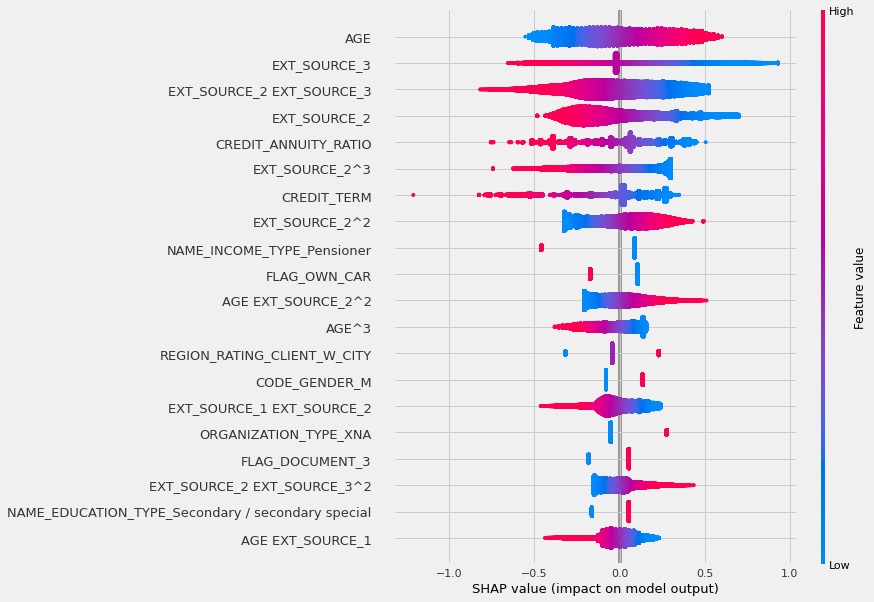

In [ ]:
shap.summary_plot(shap_values, X_train_array, feature_names = X_train.columns)

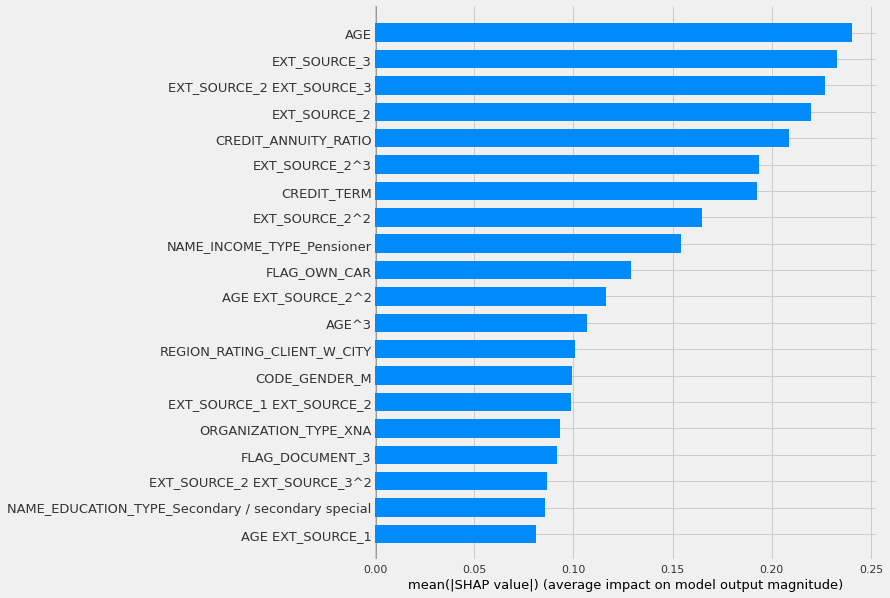

In [ ]:
shap.summary_plot(shap_values, X_train.iloc[:,:], plot_type="bar")

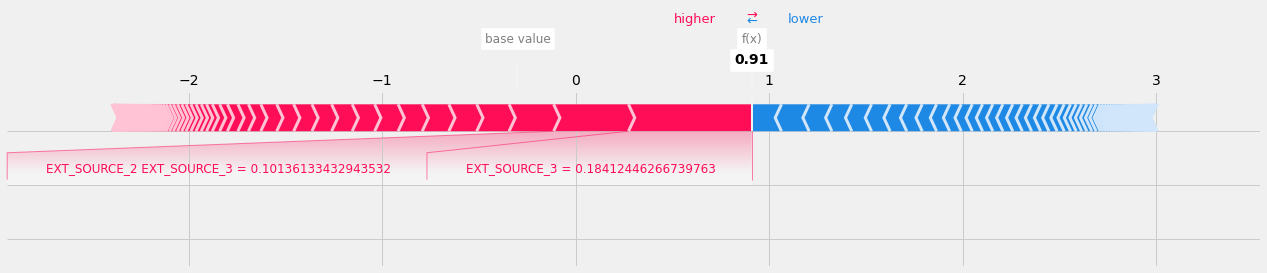

In [ ]:
shap.force_plot(explainer.expected_value,
                shap_values[0, :],
                X_train_array[0, :],
                feature_names=X_train.columns,
                matplotlib=True)

La contribution des vraibles du dataset de 250 premières linges : EXT_SOURCE_2 et EXT_SOURCE_3 contribuent le plus sur le model.
CREDIT_DOWNPAYMENT

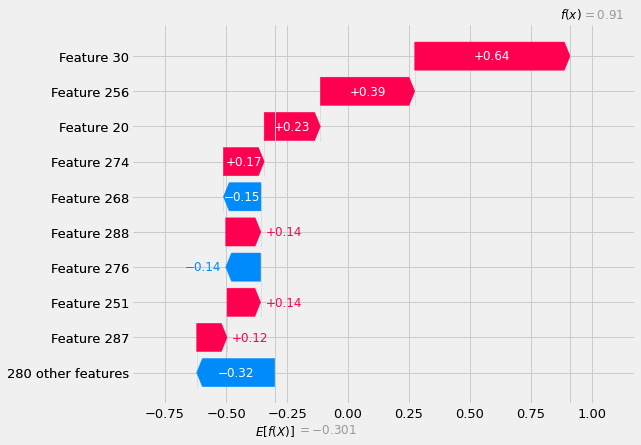

In [ ]:
#shap.plots.waterfall(shap_values[0])
shap.plots._waterfall.waterfall_legacy(explainer.expected_value, shap_values[0,:])

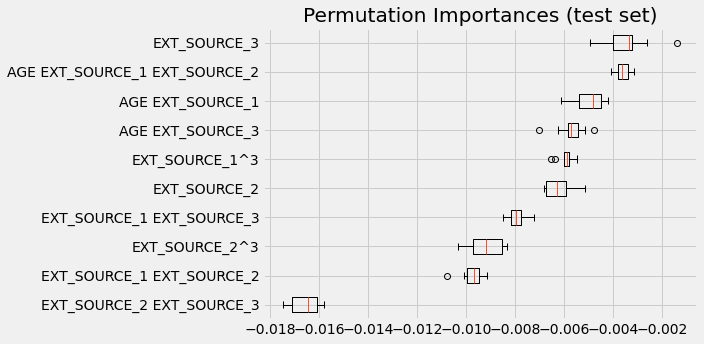

In [ ]:
#feature importance with sklearn
from sklearn.inspection import permutation_importance
permutatation = permutation_importance(lr_def, X_test.iloc[:,:], y_test, n_repeats=10, random_state=42, n_jobs=2)
sorted_idx = permutatation.importances_mean.argsort()
fig, ax = plt.subplots(figsize=(10,5))
ax.boxplot(permutatation.importances[sorted_idx][0:10].T,
           vert=False, labels=X_test.iloc[:,:].columns[sorted_idx][0:10])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()